# Autoencoder for credit card detection (Pytorch)

See example here: 

* This example: https://github.com/curiousily/Credit-Card-Fraud-Detection-using-Autoencoders-in-Keras/blob/master/fraud_detection.ipynb

* Another example: https://github.com/GitiHubi/deepAI/blob/master/GTC_2018_Lab.ipynb


## Setup

In [1]:
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import seaborn as sns

from scipy import stats
from sklearn.utils import shuffle

import pandas as pd

from sklearn.preprocessing import StandardScaler, RobustScaler, MinMaxScaler, Normalizer, QuantileTransformer, MaxAbsScaler

import torch
import torch.nn as nn
import torchvision.datasets as dsets
import torchvision.transforms as transforms
from torch.autograd import Variable
import torch.nn.functional as F

import sys
print(sys.version)
print(torch.version)
print('cuda:',torch.version.cuda)

# Choose cpu/gpu
use_gpu=1
if (use_gpu):
    print('\nEnable gpu')
    dtype = torch.cuda.FloatTensor
    device = torch.device("cuda") # Uncomment this to run on GPU
    
else:
    print('\nRun on cpu')
    dtype = torch.FloatTensor
    device = torch.device("cpu")


3.6.6 |Anaconda, Inc.| (default, Jun 28 2018, 17:14:51) 
[GCC 7.2.0]
<module 'torch.version' from '/home/donini/anaconda3/lib/python3.6/site-packages/torch/version.py'>
cuda: 9.0.176

Enable gpu


## Hyperparameters

In [2]:
num_epochs = 500
batch_size = 2048
hidden_layer1 = 100
hidden_layer2 = 100
encoding_dim = 15

'''
AUC=0.9624
Distance > 0.55
False positive rate = 0.20 %
True positive rate = 62.60 %
'''

'\nAUC=0.9624\nDistance > 0.55\nFalse positive rate = 0.20 %\nTrue positive rate = 62.60 %\n'

## Get Data

The dataset we're going to use can be downloaded from [Kaggle](https://www.kaggle.com/mlg-ulb/creditcardfraud). It contains data about credit card transactions that occurred during a period of two days, with 492 frauds out of 284,807 transactions.

All variables in the dataset are numerical. The data has been transformed using PCA transformation(s) due to privacy reasons. The two features that haven't been changed are Time and Amount. Time contains the seconds elapsed between each transaction and the first transaction in the dataset.

In [3]:
# Load data
df = pd.read_csv("data/creditcard.csv")

# Print fisrt 10 entries
print(df[:10])

   Time        V1        V2        V3        V4        V5        V6        V7  \
0   0.0 -1.359807 -0.072781  2.536347  1.378155 -0.338321  0.462388  0.239599   
1   0.0  1.191857  0.266151  0.166480  0.448154  0.060018 -0.082361 -0.078803   
2   1.0 -1.358354 -1.340163  1.773209  0.379780 -0.503198  1.800499  0.791461   
3   1.0 -0.966272 -0.185226  1.792993 -0.863291 -0.010309  1.247203  0.237609   
4   2.0 -1.158233  0.877737  1.548718  0.403034 -0.407193  0.095921  0.592941   
5   2.0 -0.425966  0.960523  1.141109 -0.168252  0.420987 -0.029728  0.476201   
6   4.0  1.229658  0.141004  0.045371  1.202613  0.191881  0.272708 -0.005159   
7   7.0 -0.644269  1.417964  1.074380 -0.492199  0.948934  0.428118  1.120631   
8   7.0 -0.894286  0.286157 -0.113192 -0.271526  2.669599  3.721818  0.370145   
9   9.0 -0.338262  1.119593  1.044367 -0.222187  0.499361 -0.246761  0.651583   

         V8        V9  ...         V21       V22       V23       V24  \
0  0.098698  0.363787  ...   -0.0183

## Construct train and test samples

In [4]:
# Get events for each class
#--------------------------
signal_sel = df[df['Class']==1]      # Signal = Fraud
background_sel = df[df['Class']==0]  # Background = Normal transactions

# Remove target (not needed)
drop=['Class']
signal_sel = signal_sel.drop(columns=drop)
background_sel = background_sel.drop(columns=drop)

# Shuffle samples 
#----------------
back = shuffle(background_sel)
sig  = shuffle(signal_sel)

varname = list(signal_sel)

# Separate Background in two (train and test)
Nb = back.shape[0]//2
x_train = back[0:Nb]
x_test_back = back[Nb+1:]

# test signal (=fraud)
x_test_signal = sig

# Combine test sample (Normal + Fraud)
x_test = pd.concat([x_test_back,x_test_signal])

print('bg all=', background_sel.shape, 'sig all=', signal_sel.shape, 'x_train=', x_train.shape,  'x_test_back=', x_test_back.shape, 'x_test_signal=', x_test_signal.shape)


bg all= (284315, 30) sig all= (492, 30) x_train= (142157, 30) x_test_back= (142157, 30) x_test_signal= (492, 30)


### Look at data

Text(0.5,0,'V11')

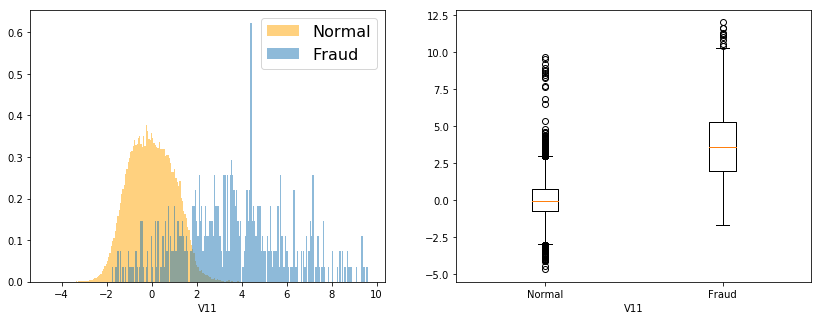

In [5]:
# Make box plots
# See: https://matplotlib.org/3.1.1/gallery/pyplots/boxplot_demo_pyplot.html#sphx-glr-gallery-pyplots-boxplot-demo-pyplot-py
# https://towardsdatascience.com/understanding-boxplots-5e2df7bcbd51

ind=11

plt.figure(figsize=(14, 5))

plt.subplot(1, 2, 1)
n, bins, patches = plt.hist(x_train.values[:,ind],bins='auto', color = 'orange', alpha=0.5, label='Normal', normed=1)
plt.hist(x_test_signal.values[:,ind], bins, alpha=0.5, label='Fraud', normed=1)
plt.xlabel(varname[ind])
plt.legend(loc='best',fontsize=16)
    
plt.subplot(1, 2, 2)
data=[x_train.values[:,ind],x_test_signal.values[:,ind]]
#data=[x_test_signal.values[:,ind]]
plt.boxplot(data)
plt.xticks([1, 2], ['Normal', 'Fraud'])
plt.xlabel(varname[ind])



Text(0.5,0,'V11')

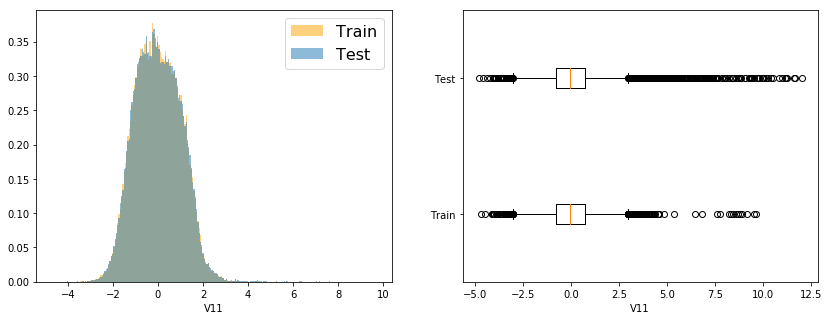

In [6]:
# Make box plots
# See: https://matplotlib.org/3.1.1/gallery/pyplots/boxplot_demo_pyplot.html#sphx-glr-gallery-pyplots-boxplot-demo-pyplot-py
# https://towardsdatascience.com/understanding-boxplots-5e2df7bcbd51

ind=11

plt.figure(figsize=(14, 5))

plt.subplot(1, 2, 1)
n, bins, patches = plt.hist(x_train.values[:,ind], bins='auto', color = 'orange', alpha=0.5, label='Train', normed=1,log=False)
plt.hist(x_test.values[:,ind], bins, alpha=0.5, label='Test', normed=1)
plt.xlabel(varname[ind])
plt.legend(loc='best',fontsize=16)
    
plt.subplot(1, 2, 2)
data=[x_train.values[:,ind],x_test.values[:,ind]]
#data=[x_test_signal.values[:,ind]]
plt.boxplot(data,vert=False)
plt.yticks([1, 2], ['Train', 'Test'])
plt.xlabel(varname[ind])



## Rescale data

In [7]:
# Rescale data
#-------------
scaler = MinMaxScaler()
#scaler = StandardScaler()
#scaler = RobustScaler()
#scaler = Normalizer()
#scaler = QuantileTransformer(output_distribution='normal', random_state=0)
#scaler = MaxAbsScaler()

# fit (get min and max) and transform x_train
x_train = scaler.fit_transform(x_train)

# transform x_test (using scale parameters of x_train)
x_test_back = scaler.transform(x_test_back)
x_test_signal = scaler.transform(x_test_signal)
x_test = scaler.transform(x_test)

print('Trial sample size: ',x_test_signal.shape)
print('Benchmark sample size: ',x_train.shape)

Trial sample size:  (492, 30)
Benchmark sample size:  (142157, 30)


## Partition training data

In [8]:
# After all of this, it's important to partition the data. In order for your model to generalize well, 
# you split the training data into two parts: a training and a validation set. 
# You will train your model on 80% of the data and validate it on 20% of the remaining training data. 

from sklearn.model_selection import train_test_split

x_train_train,x_train_valid = train_test_split(x_train,test_size=0.2,random_state=13) 
print(x_train_train.shape)
print(x_train_valid.shape)

(113725, 30)
(28432, 30)


# Load the Dataset
We shuffle the loading process of train_dataset to make the learning process independent of data orderness, but the order of test_loader remains to examine whether we can handle unspecified bias order of inputs.

In [9]:

# For training on background samples
train_loader = torch.utils.data.DataLoader(dataset=x_train_train,
                                          batch_size=batch_size,
                                          shuffle=True)

valid_loader = torch.utils.data.DataLoader(dataset=x_train_valid,
                                          batch_size=batch_size,
                                          shuffle=True)

# For testing on signal (shuffle=False)
test_loader = torch.utils.data.DataLoader(dataset=x_test_signal,
                                          batch_size=batch_size,
                                          shuffle=False)

# For testing on all training sample (shuffle=False)
train_all_loader = torch.utils.data.DataLoader(dataset=x_train,
                                          batch_size=batch_size,
                                          shuffle=False)

# For testing on unseen background sample (shuffle=False)
test_bg_loader = torch.utils.data.DataLoader(dataset=x_test_back,
                                          batch_size=batch_size,
                                          shuffle=False)


# AutoEncoder model


In [10]:
input_dim = x_train.shape[1]

class autoencoder(nn.Module):
    def __init__(self):
        super(autoencoder, self).__init__()
        self.encoder = nn.Sequential(
            nn.Linear(input_dim, hidden_layer1),
            nn.Sigmoid(),
            nn.Linear(hidden_layer1, hidden_layer2),
            nn.Sigmoid(),
            nn.Linear(hidden_layer2, encoding_dim),
            nn.Sigmoid()
        )
        self.decoder = nn.Sequential(
            nn.Linear(encoding_dim, hidden_layer2),
            nn.Sigmoid(),
            nn.Linear(hidden_layer2, hidden_layer1),
            nn.Sigmoid(),
            nn.Linear(hidden_layer1,input_dim),
            #nn.Sigmoid()
        )

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x

    
# Settings
if (use_gpu):
    model = autoencoder().cuda() # enable GPU
else:
    model = autoencoder()


# Training on Background samples


epoch [1/500], train loss:0.0049, validation loss:0.0049
epoch [50/500], train loss:0.0019, validation loss:0.0020
epoch [100/500], train loss:0.0017, validation loss:0.0017
epoch [150/500], train loss:0.0014, validation loss:0.0014
epoch [200/500], train loss:0.0012, validation loss:0.0013
epoch [250/500], train loss:0.0011, validation loss:0.0011
epoch [300/500], train loss:0.0010, validation loss:0.0010
epoch [350/500], train loss:0.0009, validation loss:0.0009
epoch [400/500], train loss:0.0008, validation loss:0.0008
epoch [450/500], train loss:0.0008, validation loss:0.0008
epoch [500/500], train loss:0.0007, validation loss:0.0007
Final train loss value: 0.0007


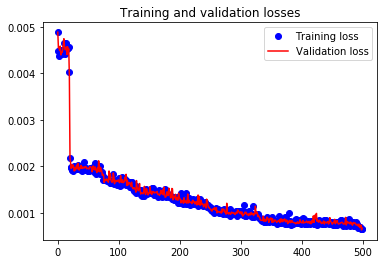

In [11]:
# Loss function: https://pytorch.org/docs/master/nn.html#loss-functions
criterion = nn.MSELoss()
#criterion = nn.L1Loss()

# Optimizer: https://pytorch.org/docs/stable/optim.html
learning_rate = 0.001  # default is 0.001
#l2_norm       = 1e-3   # L2 norm regularization (0 is no regularization)
l2_norm       = 0   # L2 norm regularization (0 is no regularization)
optimizer = torch.optim.Adam(model.parameters(),lr=learning_rate, weight_decay = l2_norm)

# Train
train_loss = []
valid_loss = []

for epoch in range(num_epochs):
    
    ###################
    # train the model #
    ###################
    model.train() # prep model for training
    for data in train_loader:
        data = data.type(dtype)
        
        output = model(data)
                
        loss = criterion(output, data)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    # record train loss
    train_loss.append(loss.item())

    ######################    
    # validate the model #
    ######################
    model.eval() # prep model for evaluation
    for data in valid_loader:
        data = data.type(dtype)
        output = model(data)
        loss = criterion(output, data)
        
    # record validation loss
    valid_loss.append(loss.item())    
    
    if (epoch==0 or (epoch+1)%50==0):
        print('epoch [{}/{}], train loss:{:.4f}, validation loss:{:.4f}'.format(epoch + 1, num_epochs, train_loss[-1],valid_loss[-1]))
    
print('Final train loss value: %.4f' % train_loss[-1])

# Plot model performance
epochs = range(num_epochs)
plt.figure()
plt.plot(epochs, train_loss, 'bo', label='Training loss')
plt.plot(epochs, valid_loss, 'r-', label='Validation loss')
plt.title('Training and validation losses')
plt.legend()
plt.savefig('images/loss.png')

## Load existing model (optional)

## Calculate distances on test and train data
Calculate L2 norm of train and test samples


In [12]:
model.eval() # Sets the module in evaluation mode.
model.cpu()  # Moves all model parameters and buffers to the CPU to avoid out of memory

autoencoder(
  (encoder): Sequential(
    (0): Linear(in_features=30, out_features=100, bias=True)
    (1): Sigmoid()
    (2): Linear(in_features=100, out_features=100, bias=True)
    (3): Sigmoid()
    (4): Linear(in_features=100, out_features=15, bias=True)
    (5): Sigmoid()
  )
  (decoder): Sequential(
    (0): Linear(in_features=15, out_features=100, bias=True)
    (1): Sigmoid()
    (2): Linear(in_features=100, out_features=100, bias=True)
    (3): Sigmoid()
    (4): Linear(in_features=100, out_features=30, bias=True)
  )
)

In [13]:
# Training sample = Normal
train_encoded = []
train_decoded = []
train_norm = []

for data in train_all_loader:
    data = data.type(dtype).cpu().detach()
    train_encoded += [model.encoder(data)]
    train_decoded += [model(data)]
    train_norm    += [model(data) - data]

train_latence = torch.cat(train_encoded).cpu().detach().numpy()
train_output  = torch.cat(train_decoded).cpu().detach().numpy()
train_distance = torch.norm(torch.cat(train_norm),dim=1)

In [14]:
# Test signal sample = Fraud

test_encoded = []
test_decoded = []
test_norm = []

for data in test_loader:
    data = data.type(dtype).cpu().detach()
    #data = data.type(dtype)
    test_encoded += [model.encoder(data)]
    test_decoded += [model(data)]
    test_norm    += [model(data) - data]

test_latence = torch.cat(test_encoded).cpu().detach().numpy()
test_output  = torch.cat(test_decoded).cpu().detach().numpy()
test_distance = torch.norm(torch.cat(test_norm),dim=1)

In [15]:
# Test background sample = Normal

test_bg_encoded = []
test_bg_decoded = []
test_bg_norm = []

for data in test_bg_loader:
    data = data.type(dtype).cpu().detach()
    #data = data.type(dtype)
    test_bg_encoded += [model.encoder(data)]
    test_bg_decoded += [model(data)]
    test_bg_norm    += [model(data) - data]

test_bg_latence = torch.cat(test_bg_encoded).cpu().detach().numpy()
test_bg_output  = torch.cat(test_bg_decoded).cpu().detach().numpy()
test_bg_distance = torch.norm(torch.cat(test_bg_norm),dim=1)

In [16]:
# Convert tensors to numpy arrays
norm_test  = test_distance.cpu().detach().numpy()
norm_train = train_distance.cpu().detach().numpy()
norm_test_bg  = test_bg_distance.cpu().detach().numpy()

# All test sample (Normal + Fraud)
norm_test_all = np.concatenate((norm_test_bg,norm_test))

## Show plot of distances


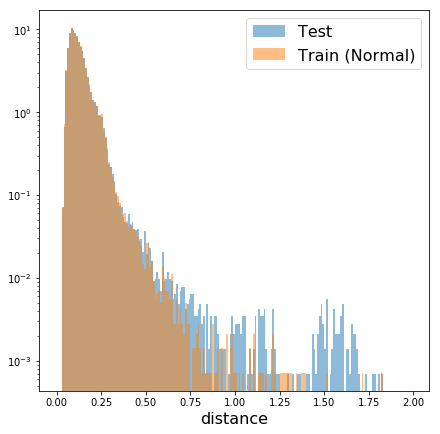

In [17]:
bins = np.arange(0, 2, 0.01)
plt.figure(figsize=(7, 7))
n, bins, patches = plt.hist(norm_test_all, bins=bins, alpha=0.5, label='Test', normed=1, log=True)
#plt.hist(norm_train, bins, alpha=0.5, label='Normal (train)', normed=1)
plt.hist(norm_train, bins, alpha=0.5, label='Train (Normal)', normed=1)
plt.xlabel('distance',fontsize=16)
plt.legend(loc='upper right',fontsize=16)
plt.savefig("images/distances.png")

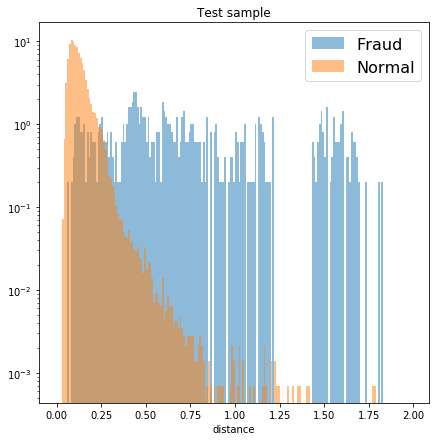

In [18]:
bins = np.arange(0, 2, 0.01)
plt.figure(figsize=(7, 7))
n, bins, patches = plt.hist(norm_test, bins=bins, alpha=0.5, label='Fraud', normed=1, log=True)
#plt.hist(norm_train, bins, alpha=0.5, label='Normal (train)', normed=1)
plt.hist(norm_test_bg, bins, alpha=0.5, label='Normal', normed=1)
plt.xlabel('distance')
plt.legend(loc='upper right',fontsize=16)
plt.title('Test sample')
plt.savefig("images/distances.png")

## Confusion matrix

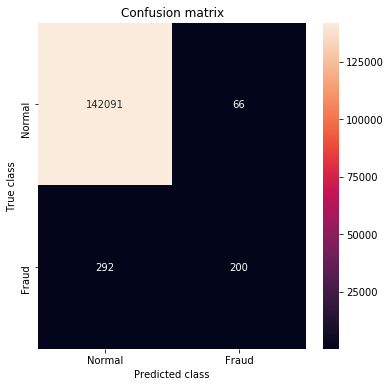

False positive rate = 0.05 %
True positive rate = 40.65 %


In [34]:
from sklearn.metrics import confusion_matrix

LABELS = ["Normal", "Fraud"]

target = np.concatenate((np.zeros(x_train.shape[0]),np.ones(x_test_signal.shape[0])))
scores = np.concatenate((norm_test_bg,norm_test))  

threshold = 0.75

y_pred = [1 if e > threshold else 0 for e in scores]
conf_matrix = confusion_matrix(target, y_pred)

plt.figure(figsize=(6, 6))
sns.heatmap(conf_matrix, xticklabels=LABELS, yticklabels=LABELS, annot=True, fmt="d");
plt.title("Confusion matrix")
plt.ylabel('True class')
plt.xlabel('Predicted class')
plt.show()

NN = conf_matrix[0,0]
NF = conf_matrix[0,1]
FN = conf_matrix[1,0]
FF = conf_matrix[1,1]
print('False positive rate = %.2f %%' % (NF/(NN+NF)*100))
print('True positive rate = %.2f %%' % (FF/(FN+FF)*100))


## ROC Curve

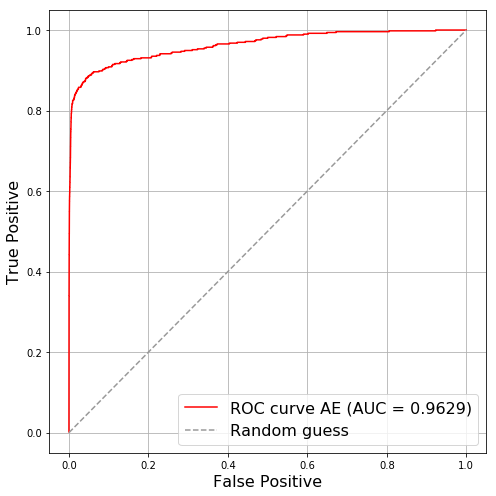

In [20]:
from sklearn.metrics import roc_curve, auc
from sklearn.model_selection import cross_val_predict

target = np.concatenate((np.zeros(x_train.shape[0]),np.ones(x_test_signal.shape[0])))
scores = np.concatenate((norm_test_bg,norm_test))  

plt.figure(figsize=(7, 7))
                   
fp, vp, thresholds = roc_curve(target,scores,pos_label=1)
roc_auc = auc(fp, vp)

plt.plot(fp,vp,color='red',label='ROC curve %s (AUC = %0.4f)'%('AE',roc_auc))

plt.xlabel('False Positive',fontsize=16)
plt.ylabel('True Positive',fontsize=16)
plt.plot([0, 1],[0, 1],
         linestyle='--',color=(0.6, 0.6, 0.6),
         label='Random guess')
#plt.plot([0, 0, 1],[0, 1, 1],color='yellow',label='Idéal')
plt.grid()
plt.legend(loc="best",fontsize=16)
plt.tight_layout()
plt.savefig("images/ROC.png")

# Save the model for future implementations